# W266 Final Project - Amazon Reviews

This notebook is to read in the cleaned data and work with the data in keras.

http://jmcauley.ucsd.edu/data/amazon/links.html

## Load in Packages

In [43]:
import pandas as pd
import gzip
import random
from collections import defaultdict
import seaborn as sns
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
import string

import tensorflow_hub as hub
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers.core import Lambda

import h5py

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

## Load in Train and Test Data

In this section, we load in the train data, and all test datasets that we plan to work with. These data include the following:

**Train:** Amazon Product Reviews - 12 Product Domains (1,200,000 reviews)

**Domains Include:**
* Video Games
* Toys and Games
* Sports and Outdoors
* Movies and TV
* Kindle Store
* Home and Kitchen
* Health and Personal Car
* Electronics
* Clothing Shoes and Jewelry
* Cell Phones and Accessories
* CDs and Vinyl
* Books

**Test and Evaluation Datasets:**
* Amazon Product Review - 12 Product Domains (120,000 reviews)
* IMDB Movie Reviews
* Yelp Reviews
* Twitter Sentiment Dataset

**Benchmark Datasets:**
* SST-2
* Yelp Polarity - Zhang et al.
* Amazon Polarity - Zhang et al.

In [45]:
def loadInitialData(loadDat = True):
    '''This function takes the data that were partitioned in the previous notebook, and loads it in.'''
    
    if loadDat == True:
        
        #Load train datasets
        train_data_name = '../../train_data.pkl'
        train_data = pd.read_pickle(train_data_name)
        
        #Load test datasets
        test_data_name = '../../test_data.pkl'
        test_data = pd.read_pickle(test_data_name)
        print('Successfully opened pickled data')
        
        return train_data, test_data

    else:
        #Else take individual files and load them in from our data subdirectory
        
        #List of file names
        files = ['reviews_Video_Games.json.gz', 
                 'reviews_Toys_and_Games.json.gz', 
                 'reviews_Sports_and_Outdoors.json.gz', 
                 'reviews_Movies_and_TV.json.gz',
                 'reviews_Kindle_Store.json.gz', 
                 'reviews_Home_and_Kitchen.json.gz',
                 'reviews_Health_and_Personal_Care.json.gz', 
                 'reviews_Electronics.json.gz',
                 'reviews_Clothing_Shoes_and_Jewelry.json.gz',
                 'reviews_Cell_Phones_and_Accessories.json.gz', 
                 'reviews_CDs_and_Vinyl.json.gz',
                 'reviews_Books.json.gz']
        
        #Descriptions for each file type to include as a value in the dataset (for EDA later)
        filesNames = ['reviews_Video_Games', 
                      'reviews_Toys_and_Games',
                      'reviews_Sports_and_Outdoors', 
                      'reviews_Movies_and_TV',
                      'reviews_Kindle_Store', 
                      'reviews_Home_and_Kitchen',
                      'reviews_Health_and_Personal_Care', 
                      'reviews_Electronics',
                      'reviews_Clothing_Shoes_and_Jewelry',
                      'reviews_Cell_Phones_and_Accessories', 
                      'reviews_CDs_and_Vinyl',
                      'reviews_Books']

        print('Looks like you dont have the data.. Will pickle it for you for future use.')
        
        def dataFullSets(original, concatData, name):
            '''
            This function is used to read in the data (each individual file), 
            and include the product domain details as a value in a column. We
            then concatenate the file being read in to the final train and test sets.
            '''
            
            #Set currentData to the dataset that is fed in
            currentData = original
            
            #Read in the dataset we want to append to currentData
            appendData = pd.read_csv('../Data/%s'%(concatData))
            
            #Append the product domain category
            appendData['Product'] = name
            
            #Append the data to currentData
            newDF = pd.concat([currentData,appendData], sort=True)
            
            return(newDF)
        
        #Read in the train dataset for the first category to initialize the dataframe
        train_data = pd.read_csv('../Data/%s_train.csv'%(filesNames[0]))
        
        #Append the product domain details
        train_data['Product'] = filesNames[0]
        
        #Read in the first category for the test data to initialize the dataframe
        test_data = pd.read_csv('../Data/%s_test.csv'%(filesNames[0]))
        
        #Append product category details
        test_data['Product'] = filesNames[0]
        
        #Set seed so that partitions are consistent
        random.seed(1203)

        #Iterate through each file and append the file train and test sets
        for fileName in filesNames[1:]:
            
            #Store the string name for the file
            concatName_train = fileName+'_train.csv'
            concatName_test = fileName+'_test.csv'

            #Feed in the datasets
            train_data = dataFullSets(train_data, concatName_train, fileName).sample(frac=1)
            test_data = dataFullSets(test_data, concatName_test, fileName).sample(frac=1)

            print('Concatenated', fileName)

        print('Finished building train and test datasets.')
        
        #Pickle data for future use
        train_data_name = '../../train_data.pkl'
        train_data.to_pickle(train_data_name)
        test_data_name = '../../test_data.pkl'
        test_data.to_pickle(test_data_name)

        print('Finished pickling for future use.')
        
        return train_data, test_data
        
train_data, test_data = loadInitialData(loadDat = True)

Successfully opened pickled data


In [46]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000


In [47]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
11262,reviews_Home_and_Kitchen,B007EESTOY,"[0, 0]",5.0,Love this! Hot drinks stay hot for a couple ho...,"06 7, 2014",A1RAD5380383DT,Jennifer Manelis,1,Great insulation!!!,1402099200
16948,reviews_Health_and_Personal_Care,B0063X0K5I,"[1, 1]",1.0,Paid for next day shipping as reviews said thi...,"05 20, 2014",AYOQUNMV9L23E,David Murray,0,Does not ship in a cold pack,1400544000
18599,reviews_Video_Games,B009CL6LA6,"[0, 0]",5.0,I got it for my teenage grandson for Christmas...,"01 30, 2014",A1Y644EFDB8CZ8,"Elaine A. Stone ""Grandma from Oklahoma""",1,Headset,1391040000
6570,reviews_Cell_Phones_and_Accessories,B0042R8ICO,"[1, 1]",5.0,"This protector is good value. It's very clear,...","08 21, 2011",A1QSXZJMDRH5KY,Yancy,1,Great Clear Protector,1313884800
207,reviews_Toys_and_Games,B003F64T1M,"[4, 4]",5.0,I've had this truck for about a week now. Afte...,"07 18, 2013",A9F5P3EMJINOR,R. Moschgat Jr.,1,Maxstone,1374105600


In [48]:
#commenting out imdb data as it has been pickled

#imdb_reviews = pd.read_csv('../Data/imdb_master_file.csv', encoding="ISO-8859-1")

#imdb_reviews['sentiment'] = np.where(imdb_reviews['label']=='pos',1,0)

#imdb_reviews = imdb_reviews.rename(index=str, columns={"review": "reviewText"})

#imdb_test = imdb_reviews.loc[imdb_reviews.type == 'test',]

#imdb_train = imdb_reviews.loc[imdb_reviews.type == 'train',]

#imdb_test.head()

In [49]:
#code to pull in and clean twitter data, commented out because it has been pickled

#twitter_reviews = pd.read_csv("../../twitter_sentiment_cleaned.csv")

#twitter_pos = twitter_reviews.loc[twitter_reviews.sentiment == 1, ['sentiment','reviewText']]
#twitter_pos = twitter_pos.head(30000)

#twitter_neg = twitter_reviews.loc[twitter_reviews.sentiment == 0, ['sentiment','reviewText']]
#twitter_neg = twitter_neg.head(30000)

#twitter_reviews = pd.concat([twitter_pos,twitter_neg], axis=0)
#twitter_reviews.shape

In [50]:
#code to pull in and clean yelp data, commented out because it has been pickled

#yelp_reviews = pd.read_csv("../../yelp_review.csv", nrows=250000)

#yelp_pos = yelp_reviews.loc[yelp_reviews.stars == 5, ['stars', 'text']]
#yelp_pos['sentiment'] = 1
#yelp_pos = yelp_pos.rename(index=str, columns = {'text':'reviewText'})
#yelp_pos = yelp_pos.drop(['stars'], axis=1)

#yelp_neg = yelp_reviews.loc[yelp_reviews.stars == 1, ['stars', 'text']]
#yelp_neg['sentiment'] = 0
#yelp_neg = yelp_neg.rename(index=str, columns = {'text':'reviewText'})
#yelp_neg = yelp_neg.drop(['stars'], axis=1)

#yelp_reviews = pd.concat([yelp_pos.head(30000), yelp_neg.head(30000)], axis=0)
#yelp_reviews.shape

In [51]:
#yelp_zhang_train = pd.read_csv('../../yelp_zhang_pol_train.csv')
yelp_zhang_test = pd.read_csv('../../yelp_zhang_pol_test.csv')

## Clean Data

Now that we have loaded in the datasets, we would like to process and standardize the data in preparation for our modeling phase. We do this in two phases because our initial modeling efforts utilized the universal sentence encoder on the entire review. Later, we decided it would be important to evaluate each individual sentence review so we have built out two separate functions to handle this.

**Some key processing details include the following:**
* Maximum review length set to 200 words
* Standardized text
    * Removed contractions for individual words
    * Standardized punctutation
    * Lowercased words
    * Removed unnecessary white space

In [52]:
max_length = 200

# def loadData(loadDat = True, test_data = test_data, train_data = train_data, 
#              yelp_zhang_train = yelp_zhang_train, yelp_zhang_test = yelp_zhang_test):
def loadData(loadDat = True, test_data = test_data, train_data = train_data, 
             yelp_zhang_test = yelp_zhang_test):

    
    if loadDat == True:
        train_data_name = '../../train_data_cleaned.pkl'
        train_data = pd.read_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned.pkl'
        test_data = pd.read_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned.pkl'
        play_data = pd.read_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned.pkl'
        twitter_reviews = pd.read_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned.pkl'
        imdb_test = pd.read_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned.pkl'
        imdb_train = pd.read_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned.pkl'
        yelp_reviews = pd.read_pickle(yelp_reviews_name)
        
        #yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned.pkl'
        #yelp_zhang_train = pd.read_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned.pkl'
        yelp_zhang_test = pd.read_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test.pkl'
        sst_test = pd.read_pickle(sst_test_name)

        amazon_zhang_test_name = '../../amazon_zhang_pol_test_cleaned.pkl'
        amazon_zhang_test = pd.read_pickle(amazon_zhang_test_name)
        
        print('Successfully opened pickled data')
        
       # return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test
    
    else:

        play_data = test_data[:10]

        def decontracted(phrase):
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase

        def prepReview(data):
            data_prep = str(data['reviewText'])
            data_prep = re.sub("[!?]", ".", data_prep)
            data_prep = re.sub("[^a-zA-Z']", " ", data_prep).lower()
            data_prep = re.sub("[\\s]+", " ", data_prep)
            data_prep = decontracted(data_prep)
            return data_prep

        #function to process review text and split into words
        def splitWords(data):
            return prepReview(data).split()[:max_length]

        #function to process review text and split into sentences
        def splitSentences(data):
            interim = prepReview(data).split()
            reviewTrunc = interim[:max_length]
            return ' '.join(reviewTrunc)


        #list of words from review into column
        sentences = play_data.apply(splitWords, axis=1)
        play_data.insert(loc = 11, column = 'sentenceWords', value = sentences)

        sentences = train_data.apply(splitWords, axis=1)
        train_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        sentences = test_data.apply(splitWords, axis=1)
        test_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

        #IMDB additions
        sentences = imdb_test.apply(splitWords, axis=1)
        imdb_test.insert(loc = 6,column = 'sentenceWords', value = sentences)
        
        sentences = imdb_train.apply(splitWords, axis=1)
        imdb_train.insert(loc = 6,column = 'sentenceWords', value = sentences)
        
        sentences = twitter_reviews.apply(splitWords, axis=1)
        twitter_reviews.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = yelp_reviews.apply(splitWords, axis=1)
        yelp_reviews.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
#         sentences = yelp_zhang_train.apply(splitWords, axis=1)
#         yelp_zhang_train.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = yelp_zhang_test.apply(splitWords, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = sst_test.apply(splitWords, axis=1)
        sst_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        sentences = amazon_zhang_test.apply(splitWords, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentenceWords', value = sentences)
        
        print('Finished working through the words for each sentences\nOn to the sentences..')

        #list of sentences from review into column
        sentences_split = play_data.apply(splitSentences, axis=1)
        play_data.insert(loc = 12, column = 'sentences', value = sentences_split)

        sentences_split = train_data.apply(splitSentences, axis=1)
        train_data.insert(loc = 12,column = 'sentences', value = sentences_split)

        sentences_split = test_data.apply(splitSentences, axis=1)
        test_data.insert(loc = 12,column = 'sentences', value = sentences_split)
        
        #IMDB additions
        sentences_split = imdb_test.apply(splitSentences, axis=1)
        imdb_test.insert(loc = 7,column = 'sentences', value = sentences_split)

        sentences_split = imdb_train.apply(splitSentences, axis=1)
        imdb_train.insert(loc = 7,column = 'sentences', value = sentences_split)
        
        sentences_split = twitter_reviews.apply(splitSentences, axis=1)
        twitter_reviews.insert(loc = 3,column = 'sentences', value = sentences_split)
        
        sentences_split = yelp_reviews.apply(splitSentences, axis=1)
        yelp_reviews.insert(loc = 3,column = 'sentences', value = sentences_split)
        
#         sentences_split = yelp_zhang_train.apply(splitSentences, axis=1)
#         yelp_zhang_train.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        sentences_split = yelp_zhang_test.apply(splitSentences, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        sentences_split = sst_test.apply(splitSentences, axis=1)
        sst_test.insert(loc = 3,column = 'sentences', value = sentences_split)
        
        sentences_split = amazon_zhang_test.apply(splitSentences, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentences', value = sentences_split)
        
        print('Finished sentences...\nNow moving on to pickling the data')

        train_data_name = '../../train_data_cleaned.pkl'
        train_data.to_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned.pkl'
        test_data.to_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned.pkl'
        play_data.to_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned.pkl'
        twitter_reviews.to_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned.pkl'
        imdb_test.to_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned.pkl'
        imdb_train.to_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned.pkl'
        yelp_reviews.to_pickle(yelp_reviews_name)

#         yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned.pkl'
#         yelp_zhang_train.to_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned.pkl'
        yelp_zhang_test.to_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test.pkl'
        sst_test.to_pickle(sst_test_name)
        
        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test.to_pickle(amazon_zhang_test_name)
        
        print('Finished pickling for future use.')
        
#         return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
        
# train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test = loadData(loadDat = True)
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test
        
train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test = loadData(loadDat = True)


Successfully opened pickled data


## Clean Data Part 2

This section allows us to store the reviews as a list of sentences that undergo the same preprocessing we did for indibidual words and the whole review, above. We include individual sentences (rather than review text) to see if this will improve the accuracies of our model when we use embeddings generated from the universal sentence encoder.

In [53]:
max_sents = 3
stop_words = set(stopwords.words('english')) 

max_sent_len = 200

# def addSents(loadDat = True, stop_words=stop_words, test_data = test_data, train_data = train_data, 
#              yelp_zhang_train = yelp_zhang_train, yelp_zhang_test = yelp_zhang_test,
#              imdb_test = imdb_test, imdb_train = imdb_train, twitter_reviews = twitter_reviews,
#              yelp_reviews = yelp_reviews, sst_test = sst_test, amazon_zhang_test = amazon_zhang_test,
#              max_sent_len = max_sent_len):
def addSents(loadDat = True, stop_words=stop_words, test_data = test_data, train_data = train_data, 
             yelp_zhang_test = yelp_zhang_test,
             imdb_test = imdb_test, imdb_train = imdb_train, twitter_reviews = twitter_reviews,
             yelp_reviews = yelp_reviews, sst_test = sst_test, amazon_zhang_test = amazon_zhang_test,
             max_sent_len = max_sent_len):
    
    if loadDat == True:
        train_data_name = '../../train_data_cleaned_sents.pkl'
        train_data = pd.read_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned_sents.pkl'
        test_data = pd.read_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned_sents.pkl'
        play_data = pd.read_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned_sents.pkl'
        twitter_reviews = pd.read_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned_sents.pkl'
        imdb_test = pd.read_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned_sents.pkl'
        imdb_train = pd.read_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned_sents.pkl'
        yelp_reviews = pd.read_pickle(yelp_reviews_name)
        
#         yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned_sents.pkl'
#         yelp_zhang_train = pd.read_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned_sents.pkl'
        yelp_zhang_test = pd.read_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test_sents.pkl'
        sst_test = pd.read_pickle(sst_test_name)

        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test = pd.read_pickle(yelp_zhang_test_name)
    
        print('Successfully opened pickled data')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test
#         return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
    
    else:

        play_data = test_data[:10]

        def decontracted(phrase):
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase

        def prepReview(data):
            data_prep = str(data['reviewText'])
            data_prep = re.sub("[!?]", ".", data_prep)
            data_prep = re.sub("[^a-zA-Z'.]", " ", data_prep).lower()
            data_prep = re.sub("\.+", " . ", data_prep)
            data_prep = re.sub("\s+", " ", data_prep)
            data_prep = decontracted(data_prep)
            return data_prep

        #function to process review text and split into words
        def splitWords(data):
            
            words = []
            for word in prepReview(data).split():
                if word not in stop_words:
                    if (word != '.' )| (word != ' .'):
                        words.append(word)
            return words[:max_length]

        #function to process review text and split into sentences
        def splitSentences(data):
            interim = prepReview(data).split('.')
            
            truncated = []
            
            for sents in interim:
                int2 = sents.split(' ')
                max_words = int2[:max_sent_len]
                truncated.append(' '.join(max_words))
            
            return truncated


        #list of words from review into column
        sentences = play_data.apply(splitWords, axis=1)
        play_data.insert(loc = 11, column = 'sentenceWords_Stops', value = sentences)

        sentences = train_data.apply(splitWords, axis=1)
        train_data.insert(loc = 11,column = 'sentenceWords_Stops', value = sentences)

        sentences = test_data.apply(splitWords, axis=1)
        test_data.insert(loc = 11,column = 'sentenceWords_Stops', value = sentences)

        #IMDB additions
        sentences = imdb_test.apply(splitWords, axis=1)
        imdb_test.insert(loc = 6,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = imdb_train.apply(splitWords, axis=1)
        imdb_train.insert(loc = 6,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = twitter_reviews.apply(splitWords, axis=1)
        twitter_reviews.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = yelp_reviews.apply(splitWords, axis=1)
        yelp_reviews.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
#         sentences = yelp_zhang_train.apply(splitWords, axis=1)
#         yelp_zhang_train.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = yelp_zhang_test.apply(splitWords, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = sst_test.apply(splitWords, axis=1)
        sst_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        sentences = amazon_zhang_test.apply(splitWords, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentenceWords_Stops', value = sentences)
        
        print('Finished working through the words for each sentences\nOn to the sentences..')

        #list of sentences from review into column
        sentences_split = play_data.apply(splitSentences, axis=1)
        play_data.insert(loc = 12, column = 'sentences_indiv', value = sentences_split)

        sentences_split = train_data.apply(splitSentences, axis=1)
        train_data.insert(loc = 12,column = 'sentences_indiv', value = sentences_split)

        sentences_split = test_data.apply(splitSentences, axis=1)
        test_data.insert(loc = 12,column = 'sentences_indiv', value = sentences_split)
        
        #IMDB additions
        sentences_split = imdb_test.apply(splitSentences, axis=1)
        imdb_test.insert(loc = 7,column = 'sentences_indiv', value = sentences_split)

        sentences_split = imdb_train.apply(splitSentences, axis=1)
        imdb_train.insert(loc = 7,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = twitter_reviews.apply(splitSentences, axis=1)
        twitter_reviews.insert(loc = 3,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = yelp_reviews.apply(splitSentences, axis=1)
        yelp_reviews.insert(loc = 3,column = 'sentences_indiv', value = sentences_split)
        
#         sentences_split = yelp_zhang_train.apply(splitSentences, axis=1)
#         yelp_zhang_train.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = yelp_zhang_test.apply(splitSentences, axis=1)
        yelp_zhang_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = sst_test.apply(splitSentences, axis=1)
        sst_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        sentences_split = amazon_zhang_test.apply(splitSentences, axis=1)
        amazon_zhang_test.insert(loc = 2,column = 'sentences_indiv', value = sentences_split)
        
        print('Finished sentences...\nNow moving on to pickling the data')

        train_data_name = '../../train_data_cleaned_sents.pkl'
        train_data.to_pickle(train_data_name)
        
        test_data_name = '../../test_data_cleaned_sents.pkl'
        test_data.to_pickle(test_data_name)
        
        play_data_name = '../../play_data_cleaned_sents.pkl'
        play_data.to_pickle(play_data_name)
        
        twitter_reviews_name = '../../twitter_reviews_cleaned_sents.pkl'
        twitter_reviews.to_pickle(twitter_reviews_name)
        
        imdb_test_name = '../../imdb_test_cleaned_sents.pkl'
        imdb_test.to_pickle(imdb_test_name)
        imdb_train_name = '../../imdb_train_cleaned_sents.pkl'
        imdb_train.to_pickle(imdb_train_name)
        
        yelp_reviews_name = '../../yelp_reviews_cleaned_sents.pkl'
        yelp_reviews.to_pickle(yelp_reviews_name)

#         yelp_zhang_train_name = '../../yelp_zhang_pol_train_cleaned_sents.pkl'
#         yelp_zhang_train.to_pickle(yelp_zhang_train_name)
        yelp_zhang_test_name = '../../yelp_zhang_pol_test_cleaned_sents.pkl'
        yelp_zhang_test.to_pickle(yelp_zhang_test_name)
        
        sst_test_name = '../../sst_test_sents.pkl'
        sst_test.to_pickle(sst_test_name)
        
        amazon_zhang_test_name = '../../amazon_zhang_test_pol_test_cleaned_sents.pkl'
        amazon_zhang_test.to_pickle(amazon_zhang_test_name)
        
        print('Finished pickling for future use.')
        
        return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test
        
train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_test, sst_test, amazon_zhang_test = addSents(loadDat = True)
#         return train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test
        
# train_data, test_data, play_data, twitter_reviews, imdb_test, imdb_train, yelp_reviews, yelp_zhang_train, yelp_zhang_test, sst_test, amazon_zhang_test = addSents(loadDat = True)


Finished working through the words for each sentences
On to the sentences..
Finished sentences...
Now moving on to pickling the data
Finished pickling for future use.


In [54]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime,sentenceWords_Stops,sentences_indiv,sentenceWords,sentences
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400,"[received, screen, protector, ., going, back, ...","[just received my screen protector , it is go...","[just, received, my, screen, protector, it, is...",just received my screen protector it is going ...
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600,"[instead, orchestra, treated, wonderful, sound...",[but instead of the orchestra we are treated t...,"[but, instead, of, the, orchestra, we, are, tr...",but instead of the orchestra we are treated to...
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000,"[love, shaving, soap, best, price, ., gives, b...",[love this shaving soap and it was the best pr...,"[love, this, shaving, soap, and, it, was, the,...",love this shaving soap and it was the best pri...
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600,"[impossible, join, two, pieces, cappuccino, ma...",[it is impossible to join the two pieces of th...,"[it, is, impossible, to, join, the, two, piece...",it is impossible to join the two pieces of the...
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000,"[suction, little, vacuum, cleaner, ., work, .,...",[there is no suction on this little vacuum cle...,"[there, is, no, suction, on, this, little, vac...",there is no suction on this little vacuum clea...


In [55]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime,sentenceWords_Stops,sentences_indiv,sentenceWords,sentences
11262,reviews_Home_and_Kitchen,B007EESTOY,"[0, 0]",5.0,Love this! Hot drinks stay hot for a couple ho...,"06 7, 2014",A1RAD5380383DT,Jennifer Manelis,1,Great insulation!!!,1402099200,"[love, ., hot, drinks, stay, hot, couple, hour...","[love this , hot drinks stay hot for a couple...","[love, this, hot, drinks, stay, hot, for, a, c...",love this hot drinks stay hot for a couple hou...
16948,reviews_Health_and_Personal_Care,B0063X0K5I,"[1, 1]",1.0,Paid for next day shipping as reviews said thi...,"05 20, 2014",AYOQUNMV9L23E,David Murray,0,Does not ship in a cold pack,1400544000,"[paid, next, day, shipping, reviews, said, pro...",[paid for next day shipping as reviews said th...,"[paid, for, next, day, shipping, as, reviews, ...",paid for next day shipping as reviews said thi...
18599,reviews_Video_Games,B009CL6LA6,"[0, 0]",5.0,I got it for my teenage grandson for Christmas...,"01 30, 2014",A1Y644EFDB8CZ8,"Elaine A. Stone ""Grandma from Oklahoma""",1,Headset,1391040000,"[got, teenage, grandson, christmas, ., loves, ...",[i got it for my teenage grandson for christma...,"[i, got, it, for, my, teenage, grandson, for, ...",i got it for my teenage grandson for christmas...
6570,reviews_Cell_Phones_and_Accessories,B0042R8ICO,"[1, 1]",5.0,"This protector is good value. It's very clear,...","08 21, 2011",A1QSXZJMDRH5KY,Yancy,1,Great Clear Protector,1313884800,"[protector, good, value, ., clear, attaches, w...","[this protector is good value , it is very cl...","[this, protector, is, good, value, it, is, ver...",this protector is good value it is very clear ...
207,reviews_Toys_and_Games,B003F64T1M,"[4, 4]",5.0,I've had this truck for about a week now. Afte...,"07 18, 2013",A9F5P3EMJINOR,R. Moschgat Jr.,1,Maxstone,1374105600,"[truck, week, ., unpacking, first, thought, bi...","[i have had this truck for about a week now , ...","[i, have, had, this, truck, for, about, a, wee...",i have had this truck for about a week now aft...


In [13]:
yelp_zhang_test['sentenceWords_Stops'].head()

0    [contrary, reviews, zero, complaints, service,...
1    [last, summer, appointment, get, new, tires, w...
2    [friendly, staff, starbucks, fair, get, anywhe...
3    [food, good, ., unfortunately, service, hit, m...
4    [even, car, filene, basement, worth, bus, trip...
Name: sentenceWords_Stops, dtype: object

In [14]:
yelp_zhang_test['sentences_indiv'].head()

0    [contrary to other reviews i have zero complai...
1    [last summer i had an appointment to get new t...
2    [friendly staff same starbucks fair you get an...
3    [the food is good ,  unfortunately the service...
4    [even when we did not have a car filene is bas...
Name: sentences_indiv, dtype: object

In [15]:
amazon_zhang_test.head()

,sentiment,reviewText,sentences_indiv,sentenceWords_Stops,sentences,sentenceWords
0,1,"Contrary to other reviews, I have zero complai...",[contrary to other reviews i have zero complai...,"[contrary, reviews, zero, complaints, service,...",contrary to other reviews i have zero complain...,"[contrary, to, other, reviews, i, have, zero, ..."
1,0,Last summer I had an appointment to get new ti...,[last summer i had an appointment to get new t...,"[last, summer, appointment, get, new, tires, w...",last summer i had an appointment to get new ti...,"[last, summer, i, had, an, appointment, to, ge..."
2,1,"Friendly staff, same starbucks fair you get an...",[friendly staff same starbucks fair you get an...,"[friendly, staff, starbucks, fair, get, anywhe...",friendly staff same starbucks fair you get any...,"[friendly, staff, same, starbucks, fair, you, ..."
3,0,The food is good. Unfortunately the service is...,"[the food is good , unfortunately the service...","[food, good, ., unfortunately, service, hit, m...",the food is good unfortunately the service is ...,"[the, food, is, good, unfortunately, the, serv..."
4,1,Even when we didn't have a car Filene's Baseme...,[even when we did not have a car filene is bas...,"[even, car, filene, basement, worth, bus, trip...",even when we did not have a car filene is base...,"[even, when, we, did, not, have, a, car, filen..."


## Initial Exploratory Data Analysis for Standardized Text

Prior to modeling efforts and utilizing the universal sentence encoder, we conducted some basic exploratory data analysis on our training dataset.

### Word Frequency

We first wanted to look at how often each word occurs pre and post removal of stop words. Given that these are typically short reviews, and we have limited the review text length to 200 words, we will likely get a great deal of overlap. As we can see from the histograms, below, there is a great deal of words that don't occur frequently.

In [23]:
wordFreq = defaultdict(int)

wordData = list(train_data['sentenceWords'])

for row in wordData:
    for word in row:
        wordFreq[word] += 1      

In [24]:
wordsForHist = list(wordFreq.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

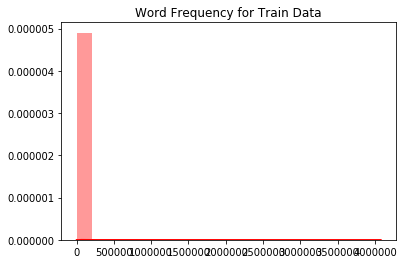

In [25]:
sns.distplot(wordsForHist, bins=20, color = 'red').set_title('Word Frequency for Train Data')

In [26]:
wordFreq2 = defaultdict(int)

wordData2 = list(train_data['sentenceWords_Stops'])

for row in wordData2:
    for word in row:
        wordFreq2[word] += 1      

In [27]:
wordsForHist2 = list(wordFreq2.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

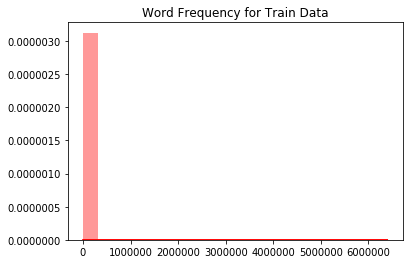

In [28]:
sns.distplot(wordsForHist2, bins=20, color = 'red').set_title('Word Frequency for Train Data Without Stop Words')

### Review Length - Individual Words

Although we have cut review length down to 200 words, we see that, on average, reviews are around 68 words long. When removing stop words, we see that the review length reduces down to about 42 words per review.

In [29]:
reviewLength = []

for row in wordData:
    reviewLength.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

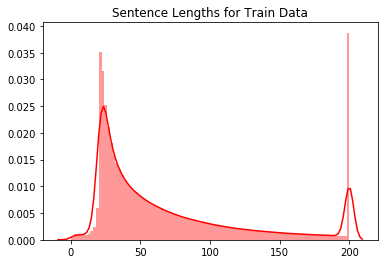

In [30]:
sns.distplot(reviewLength, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [31]:
print('Mean:',np.mean(reviewLength))
print('Median:',np.median(reviewLength))

Mean: 68.83632083333333
Median: 47.0


In [32]:
reviewLength2 = []

for row in wordData2:
    reviewLength2.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

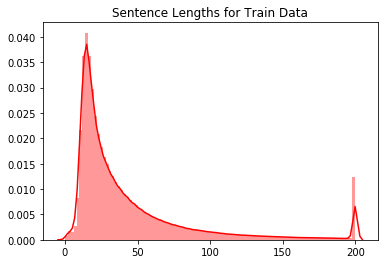

In [33]:
sns.distplot(reviewLength2, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [34]:
print('Mean:',np.mean(reviewLength2))
print('Median:',np.median(reviewLength2))

Mean: 42.20296916666667
Median: 26.0


### Review Length - Sentences

As stated earlier, we plan to investigate the effect of feeding in individual sentences into the universal sentence encoder. As we can see below, reviews are typically 5~6 sentences long. This varies between domains. Although, intially, we decided to cut down the number of sentences to include to 5 sentences, data processing became too expensive. As a result, we have reduced the number of sentences to include down to 3 sentences.

In [35]:
num_sents = []

reviewSents = train_data['sentences_indiv']
print(list(train_data['reviewText'][4:5]))
print(list(train_data['sentences'][4:5]))
print(list(reviewSents[4:5]))

for sents in reviewSents:
    num_sents.append(len(sents))

["There is no suction on this little vacuum cleaner....it just doesn't work. No, I would not recommend it to anyone."]
['there is no suction on this little vacuum cleaner it just does not work no i would not recommend it to anyone']
[['there is no suction on this little vacuum cleaner ', ' it just does not work ', ' no i would not recommend it to anyone ', ' ']]


/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Number of Sentences for Train Data')

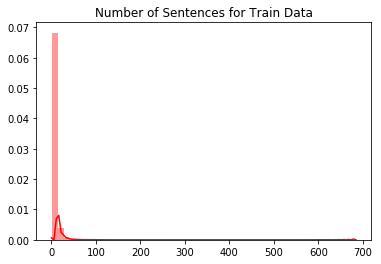

In [36]:
sns.distplot(num_sents, bins=50, color = 'red').set_title('Number of Sentences for Train Data')

In [37]:
print('Mean:',np.mean(num_sents))
print('Median:',np.median(num_sents))

Mean: 6.654093333333333
Median: 5.0


## Universal Sentence Encoder

In [56]:
#embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [57]:
def getUniSentEmbeds(data):

    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        review_embeddings = sess.run(embedding((data)))

    review_embeddings = np.array(review_embeddings)
    return review_embeddings

In [58]:
def loadUniSentEncod(data, link):

    try:
        data_USE = np.load(link)
        print(f'Successfully opened data from {link}')

    except FileNotFoundError:

        data_reviews = [str(rev) for rev in data['sentences']]

        print('Build Universal Sentence Encoder Data')
        data_USE = getUniSentEmbeds(data_reviews)

        np.save(link, data_USE)

        print(f'Finished pickling data for future use as {link}.')
        
    return data_USE

In [59]:
#Load universal sentence encoder embeddings for play data
play_data_link = '../../play_data_USE.npy'
play_data_USE = loadUniSentEncod(play_data,play_data_link)

test_data_name = '../../test_data_USE.npy'
test_data_USE = loadUniSentEncod(test_data,test_data_name)

train_data_name = '../../train_data_USE.npy'
train_data_USE = loadUniSentEncod(train_data,train_data_name)

imdb_test_data_name = '../../imdb_test_data_USE.npy'
imdb_test_USE = loadUniSentEncod(imdb_test,imdb_test_data_name)

imdb_train_data_name = '../../imdb_train_data_USE.npy'
imdb_train_USE = loadUniSentEncod(imdb_train,imdb_train_data_name)

twitter_data_name = '../../twitter_data_USE.npy'
twitter_test_USE = loadUniSentEncod(twitter_reviews,twitter_data_name)

yelp_data_name = '../../yelp_data_USE.npy'
yelp_test_USE = loadUniSentEncod(yelp_reviews,yelp_data_name)

# yelp_data_name = '../../yelp_zhang_train_USE.npy'
# yelp_zhang_train_USE = loadUniSentEncod(yelp_zhang_train,yelp_data_name)

yelp_data_name = '../../yelp_zhang_test_USE.npy'
yelp_zhang_test_USE = loadUniSentEncod(yelp_zhang_test,yelp_data_name)

amazon_data_name = '../../amazon_zhang_test_USE.npy'
amazon_zhang_test_USE = loadUniSentEncod(amazon_zhang_test,amazon_data_name)

sst_data_name = '../../sst_test_USE.npy'
sst_test_USE = loadUniSentEncod(sst_test,sst_data_name)

Build Universal Sentence Encoder Data
Finished pickling data for future use as ../../test_data_USE.npy.


In [58]:
data_reviews = [rev for rev in train_data['sentences_indiv']]

lengths = []

for revs in data_reviews:
    interimLen = []
    for rev in revs:
        interimLen.append(len(rev))
    lengths.append(max(interimLen))

In [66]:
max(lengths)

5537

In [65]:
look = train_data.iloc[717916]


len(look['reviewText'])

15446

## Sentence level USE

In [60]:
def getUniSentEmbeds_sents(data):

    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        
        review_embeddings = sess.run(embedding((data)))

    review_embeddings = np.array(review_embeddings)
    return review_embeddings

In [61]:
sent_length = 3


def loadUniSentEncod_sents(data, link1, link2, Load = True, sent_length = sent_length):

    if Load == True:
        data_np = np.load(link1)
        print(f'Successfully opened data from {link1}')
        
        data_np_avg = np.load(link2)
        print(f'Successfully opened data from {link2}')
        
        return data_np, data_np_avg

    else:
    
        data_reviews = [rev for rev in data['sentences_indiv']]
        
        dim1 = len(data_reviews)
        dim2 = sent_length
        
        new_dat = []
        
        data_USE = []
        data_USE_avg = []
        for rev in data_reviews:
            if len(rev) < 3:
                rev.append(' ')
                rev.append(' ')
        
            new_dat.extend(rev[:sent_length])
                    
        interim = getUniSentEmbeds_sents(new_dat)
        
        print('interim shape =',interim.shape)
        
        data_USE = interim.reshape((dim1,dim2,512))
        
        for revs in data_USE:
            
            interim2 = list(np.average(revs, axis = 0))
            data_USE_avg.extend([interim2])

        data_np = np.array([np.reshape(embed, (len(embed),512)) for embed in data_USE])

        np.save(link1, data_USE)
        print(f'Finished pickling data for future use as {link1}.')

        data_np_avg = np.array([np.reshape(embed, (len(embed),1)) for embed in data_USE_avg])
        np.save(link2, data_np_avg)
        print(f'Finished pickling data for future use as {link2}.')

        
    return data_np, data_np_avg

In [62]:
save_link1 = '../../play_data_sent_USE_ind.npy'
save_link2 = '../../play_data_sent_USE_avg.npy'

play_data_sent_USE_ind,  play_data_sent_USE_avg= loadUniSentEncod_sents(play_data, 
                                                                        save_link1, 
                                                                        save_link2,
                                                                        Load = True)

Successfully opened data from ../../play_data_sent_USE_ind.npy
Successfully opened data from ../../play_data_sent_USE_avg.npy


In [63]:
save_link1 = '../../train_data_sent_USE_ind1.npy'
save_link2 = '../../train_data_sent_USE_avg1.npy'

train_data_sent_USE_ind1,  train_data_sent_USE_avg1= loadUniSentEncod_sents(train_data[:400000], 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

save_link1 = '../../train_data_sent_USE_ind2.npy'
save_link2 = '../../train_data_sent_USE_avg2.npy'

train_data_sent_USE_ind2,  train_data_sent_USE_avg2= loadUniSentEncod_sents(train_data[400000:800000], 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

save_link1 = '../../train_data_sent_USE_ind3.npy'
save_link2 = '../../train_data_sent_USE_avg3.npy'

train_data_sent_USE_ind3,  train_data_sent_USE_avg3= loadUniSentEncod_sents(train_data[800000:], 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

train_data_sent_USE_ind = np.concatenate((train_data_sent_USE_ind1,
                                          train_data_sent_USE_ind2,
                                          train_data_sent_USE_ind3), axis = 0)  

train_data_sent_USE_avg = np.concatenate((train_data_sent_USE_avg1,
                                          train_data_sent_USE_avg2,
                                          train_data_sent_USE_avg3), axis = 0)

print(train_data_sent_USE_ind.shape)
print(train_data_sent_USE_avg.shape)


Successfully opened data from ../../train_data_sent_USE_ind1.npy
Successfully opened data from ../../train_data_sent_USE_avg1.npy
Successfully opened data from ../../train_data_sent_USE_ind2.npy
Successfully opened data from ../../train_data_sent_USE_avg2.npy
Successfully opened data from ../../train_data_sent_USE_ind3.npy
Successfully opened data from ../../train_data_sent_USE_avg3.npy
(1200000, 3, 512)
(1200000, 512, 1)


In [64]:
save_link1 = '../../test_data_sent_USE_ind.npy'
save_link2 = '../../test_data_sent_USE_avg.npy'

test_data_sent_USE_ind,  test_data_sent_USE_avg= loadUniSentEncod_sents(test_data, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

interim shape = (720000, 512)
Finished pickling data for future use as ../../test_data_sent_USE_ind.npy.
Finished pickling data for future use as ../../test_data_sent_USE_avg.npy.


In [24]:
save_link1 = '../../imdb_test_data_sent_USE_ind.npy'
save_link2 = '../../imdb_test_data_sent_USE_avg.npy'

imdb_test_data_sent_USE_ind,  imdb_test_data_sent_USE_avg= loadUniSentEncod_sents(imdb_test, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

save_link1 = '../../twitter_reviews_data_sent_USE_ind.npy'
save_link2 = '../../twitter_reviews_data_sent_USE_avg.npy'

twitter_reviews_data_sent_USE_ind,  twitter_reviews_data_sent_USE_avg= loadUniSentEncod_sents(twitter_reviews, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)
save_link1 = '../../yelp_reviews_data_sent_USE_ind.npy'
save_link2 = '../../yelp_reviews_data_sent_USE_avg.npy'

yelp_reviews_data_sent_USE_ind,  yelp_reviews_data_sent_USE_avg= loadUniSentEncod_sents(yelp_reviews, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

save_link1 = '../../yelp_zhang_test_data_sent_USE_ind.npy'
save_link2 = '../../yelp_zhang_test_data_sent_USE_avg.npy'

yelp_zhang_test_data_sent_USE_ind,  yelp_zhang_test_data_sent_USE_avg= loadUniSentEncod_sents(yelp_zhang_test,  
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

Successfully opened data from ../../imdb_test_data_sent_USE_ind.npy
Successfully opened data from ../../imdb_test_data_sent_USE_avg.npy
Successfully opened data from ../../twitter_reviews_data_sent_USE_ind.npy
Successfully opened data from ../../twitter_reviews_data_sent_USE_avg.npy
Successfully opened data from ../../yelp_reviews_data_sent_USE_ind.npy
Successfully opened data from ../../yelp_reviews_data_sent_USE_avg.npy
Successfully opened data from ../../yelp_zhang_test_data_sent_USE_ind.npy
Successfully opened data from ../../yelp_zhang_test_data_sent_USE_avg.npy
Successfully opened data from ../../amazon_zhang_test_data_sent_USE_ind.npy
Successfully opened data from ../../amazon_zhang_test_data_sent_USE_avg.npy
Successfully opened data from ../../sst_test_data_sent_USE_ind.npy
Successfully opened data from ../../sst_test_data_sent_USE_avg.npy


In [69]:
save_link1 = '../../amazon_zhang_test_data_sent_USE_ind.npy'
save_link2 = '../../amazon_zhang_test_data_sent_USE_avg.npy'

amazon_zhang_test_data_sent_USE_ind,  amazon_zhang_test_data_sent_USE_avg= loadUniSentEncod_sents(amazon_zhang_test, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

save_link1 = '../../sst_test_data_sent_USE_ind.npy'
save_link2 = '../../sst_test_data_sent_USE_avg.npy'

sst_test_data_sent_USE_ind,  sst_test_data_sent_USE_avg= loadUniSentEncod_sents(sst_test, 
                                                                          save_link1, 
                                                                          save_link2,
                                                                          Load = True)

interim shape = (114000, 512)
Finished pickling data for future use as ../../amazon_zhang_test_data_sent_USE_ind.npy.
Finished pickling data for future use as ../../amazon_zhang_test_data_sent_USE_avg.npy.
Successfully opened data from ../../sst_test_data_sent_USE_ind.npy
Successfully opened data from ../../sst_test_data_sent_USE_avg.npy


## Keras

### TO DO:

**Model Efforts**
* Initialize and access word2vec embeddings in CNN
* Initialize and access glove embeddings in CNN
* Index Universal Sentence Embeddings for concatenation in CNN

**Text Processing**
* Contractions
* Review Length (some as large as 6000?!)
* Stopwords

### Baseline Models
#### CNN
* Trained Embeddings
* Word2Vec
* Glove

#### Softmax
* Universal Sentence Encoder (USE)

### Models to Test
#### CNN (Concatentation)
* Trained Embeddings + USE
* Word2Vec + USE
* Glove + USE

**If extra time**
* Zero shot learning - IMDB Reviews
* Sentiment embeddings

In [39]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime,sentenceWords_Stops,sentences_indiv,sentenceWords,sentences
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,1376438400,"[received, screen, protector, ., going, back, ...","[just received my screen protector , it is go...","[just, received, my, screen, protector, it, is...",just received my screen protector it is going ...
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,1009065600,"[instead, orchestra, treated, wonderful, sound...",[but instead of the orchestra we are treated t...,"[but, instead, of, the, orchestra, we, are, tr...",but instead of the orchestra we are treated to...
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,1358208000,"[love, shaving, soap, best, price, ., gives, b...",[love this shaving soap and it was the best pr...,"[love, this, shaving, soap, and, it, was, the,...",love this shaving soap and it was the best pri...
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,1314489600,"[impossible, join, two, pieces, cappuccino, ma...",[it is impossible to join the two pieces of th...,"[it, is, impossible, to, join, the, two, piece...",it is impossible to join the two pieces of the...
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,1359072000,"[suction, little, vacuum, cleaner, ., work, .,...",[there is no suction on this little vacuum cle...,"[there, is, no, suction, on, this, little, vac...",there is no suction on this little vacuum clea...


In [65]:
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)

list_sentences_train = list(train_data['sentenceWords'])

tokenizer = Tokenizer()   #num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

word_index = tokenizer.word_index

vocabulary_size = len(word_index) + 1
vocabulary_size

embedDim=300

def standardizeData(data, tokenModel = tokenizer):
    dataSentences = list(data['sentenceWords'])
    list_token_data = tokenModel.texts_to_sequences(dataSentences)
    
    data_tokenized = pad_sequences(list_token_data, maxlen=max_length, padding='post')
    data_labels = np.array(data['sentiment'])
    
    return data_tokenized, data_labels

X_train, X_train_labels = standardizeData(train_data)
X_test, X_test_labels = standardizeData(test_data)
X_imdb_train, X_imdb_train_labels = standardizeData(imdb_train)
X_imdb_test, X_imdb_test_labels = standardizeData(imdb_test)
X_twitter_test, X_twitter_test_labels = standardizeData(twitter_reviews)
X_yelp_test, X_yelp_test_labels = standardizeData(yelp_reviews)
#X_yelp_zhang_train, X_yelp_zhang_train_labels = standardizeData(yelp_zhang_train)
X_yelp_zhang_test, X_yelp_zhang_test_labels = standardizeData(yelp_zhang_test)
X_amazon_zhang_test, X_amazon_zhang_test_labels = standardizeData(amazon_zhang_test)

sst_dataSentences = list(sst_test['sentenceWords'])

sst_list_token_data = tokenizer.texts_to_sequences(sst_dataSentences)

X_sst_test = pad_sequences(sst_list_token_data, maxlen=max_length, padding='post')

## Word2Vec Embeddings

In [66]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

def loadw2v(loadEmbed = True):
    if loadEmbed == True:
        w2v_embed_name = '../../w2v_embed.npy'
        embedding_matrix_w2v = np.load(w2v_embed_name)

        print('Successfully opened pickled embedding_matrix_w2v')
        return embedding_matrix_w2v
    else:
        
        word_vectors = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin.gz', binary=True)
        embedding_matrix_w2v = np.zeros((vocabulary_size, embedDim))
        
        for word, i in word_index.items():
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix_w2v[i] = embedding_vector
            except KeyError:
                embedding_matrix_w2v[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

        del(word_vectors)
        
        w2v_embed_name = '../../w2v_embed.npy'
        np.save(w2v_embed_name, embedding_matrix_w2v)
        
        return embedding_matrix_w2v

embedding_matrix_w2v = loadw2v(loadEmbed = True)

Successfully opened pickled embedding_matrix_w2v


In [67]:
embedding_matrix_w2v

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       ...,
       [-0.05669782,  0.66833448, -0.72440838, ...,  0.02165054,
         0.02798013, -0.29262374],
       [-0.44889479, -0.14608567,  0.41548637, ...,  0.01506322,
        -0.41868808,  0.33303135],
       [ 0.09562571, -0.18635412, -0.26843286, ..., -0.53592383,
         0.25208398, -0.16169312]])

In [68]:
embedding_matrix_w2v.shape

(385239, 300)

## Glove Embeddings

In [69]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

# https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
# import warnings
# # warnings.filterwarnings("ignore")

# _ = glove2word2vec(glove_input_file='../../glove.840B.300d.txt', 
#                    word2vec_output_file='../../gensim_glove_vectors.txt')

In [70]:
def loadGlove(loadEmbed = True):
    if loadEmbed == True:
        glove_embed_name = '../../glove_embed.npy'
        embedding_matrix_glove = np.load(glove_embed_name)

        print('Successfully opened pickled embedding_matrix_glove')
        return embedding_matrix_glove
    
    else:
        word_vectors = KeyedVectors.load_word2vec_format('../../gensim_glove_vectors.txt', binary=False)

        embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
        for word, i in word_index.items():
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix_glove[i] = embedding_vector
            except KeyError:
                embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

        del(word_vectors)
        
        glove_embed_name = '../../glove_embed.npy'
        np.save(glove_embed_name, embedding_matrix_glove)
        
        return embedding_matrix_glove

embedding_matrix_glove = loadGlove(loadEmbed = True)

Successfully opened pickled embedding_matrix_glove


In [71]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27204001, -0.06203   , -0.1884    , ...,  0.13015001,
        -0.18317001,  0.1323    ],
       [ 0.18732999,  0.40595001, -0.51174003, ...,  0.16495   ,
         0.18757001,  0.53873998],
       ...,
       [-0.38305282,  0.51873904,  0.42807558, ..., -0.06607605,
         0.51693713,  0.53094775],
       [-0.00126892, -0.1897983 ,  0.0538873 , ..., -0.23339596,
        -0.33180575,  0.02143054],
       [ 0.95435669,  0.0096887 , -0.26980815, ...,  0.11325344,
        -0.11042341, -0.13675645]])

In [72]:
embedding_matrix_glove.shape

(385239, 300)

## CNN Model

In [73]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

def CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=max_length,
                 vocab=vocabulary_size, pool=2, denseInputs=10, train=False):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    
    k1_inputs = Input(shape=(length,))
    k2_inputs = Input(shape=(length,))
    k3_inputs = Input(shape=(length,))
       
    if embeds == None:
        k1_embeddings = Embedding(vocab, embedDepth)(k1_inputs)
        k2_embeddings = Embedding(vocab, embedDepth)(k2_inputs)
        k3_embeddings = Embedding(vocab, embedDepth)(k3_inputs)

    elif embeds == 'w2v':
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k3_inputs)
        
    elif embeds == 'Glove':
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k3_inputs)
    else:
        print('Specify embeds correctly. Currently embeds =',embeds)
        return
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)

    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    if use == True:
        use_inputs = Input(shape=(512,))
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten, use_inputs])
    else:
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    if use == True:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs, use_inputs], outputs=cnnOutputs)
    else:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    # simple early stopping
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
#     mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    print(model.summary())
        
    #plot_model(model, show_shapes=True, to_file='CNNModel.png')
        
    return model


## Simple Softmax for Baseline USE Outputs

In [74]:
def simpleSoft(length=512, act = 'relu', denseInputs=10):
    
    universalEmbeddings = Input(shape=(length,))
    
    denseLayer = Dense(denseInputs, activation=act)(universalEmbeddings)
    denseOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    model = Model(inputs=[universalEmbeddings], outputs=denseOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    print(model.summary())
                
    return model

In [54]:
simpleSoftUSE = simpleSoft(denseInputs=20)

simpleSoftUSE.fit([train_data_USE], X_train_labels, epochs=5, batch_size=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                10260     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 10,281
Trainable params: 10,281
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1200000/1200000 [==============================] - 5s 4us/step - loss: 0.3937 - acc: 0.8581
Epoch 2/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2609 - acc: 0.8949
Epoch 3/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2509 - acc: 0.8987
Epoch 4/5
1200000/1200000 [==============================] - 3s 3us/step - loss: 0.2467 - a

In [55]:
simpleSoftUSE.save('../../SimpleSoftmax_USE.h5')

In [56]:
simpleSoftUSE = load_model('../../SimpleSoftmax_USE.h5')

In [57]:
train_acc = simpleSoftUSE.evaluate([train_data_USE], X_train_labels, verbose=0)

In [58]:
test_acc = simpleSoftUSE.evaluate([test_data_USE], X_test_labels, verbose=0)

In [59]:
print('Simple Dense Layer to Softmax Accuracy using USE\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

Simple Dense Layer to Softmax Accuracy using USE
Train: 0.902, Test: 0.899


## Build and Evaluate CNN w/ Glove + USE

In [34]:
#embeds can be None, 'w2v', or 'Glove'
#if use is True, you need to adjust the cnnModel.fit to include the USE outputs as an input

cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=True, length=max_length,
                 pool=2, denseInputs=10, train=False)

cnnModel.fit([X_train,X_train,X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     115571700   input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [39]:
cnnModel.save('../../CNNModel_200MaxL_Glove_USE.h5')

In [ ]:
cnnModel = load_model('../../CNNModel_200MaxL_Glove_USE.h5')

In [ ]:
train_acc = cnnModel.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)

In [29]:
train_acc

0.9668933333333334

In [35]:
test_acc = cnnModel.evaluate([X_test, X_test, X_test, test_data_USE], X_test_labels, verbose=0)

In [36]:
print('CNN Model Accuracy using Glove + USE\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.967, Test: 0.966


## Build and Evaluate CNN w/ Glove

In [39]:
cnnModel2 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel2.fit([X_train,X_train,X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel2.save('../../CNNModel_200MaxL_Glove.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     115571700   input_5[0][0]                    
__________________________________________________________________________________________________
embedding_

In [45]:
cnnModel2 = load_model('../../CNNModel_200MaxL_Glove.h5')

In [47]:
train_acc = cnnModel2.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.304349864111344, 0.9415758333333333]

In [48]:
test_acc = cnnModel2.evaluate([X_test, X_test, X_test], X_test_labels, verbose=0)
test_acc

[0.304349864111344, 0.9415758333333333]

In [49]:
print('CNN Model Accuracy using Glove\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using Glove
Train: 0.942, Test: 0.942


## Build and Evaluate CNN w/ word2vec

In [50]:
cnnModel3 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='w2v', use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel3.fit([X_train,X_train,X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel3.save('../../CNNModel_200MaxL_w2v.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 200, 300)     115571700   input_11[0][0]                   
__________________________________________________________________________________________________
embedding_

In [ ]:
cnnModel3 = load_model('../../CNNModel_200MaxL_w2v.h5')

In [51]:
train_acc = cnnModel3.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.29983700858175755, 0.9432]

In [52]:
test_acc = cnnModel3.evaluate([X_test, X_test, X_test], X_test_labels, verbose=0)
test_acc

[0.29983700858175755, 0.9432]

In [54]:
print('CNN Model Accuracy using w2v\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using w2v
Train: 0.943, Test: 0.943


In [39]:
cnnModel4 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='w2v', use=True, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel4.fit([X_train, X_train, X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

cnnModel4.save('../../CNNModel_200MaxL_w2v_USE.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 300)     115571700   input_12[0][0]                   
__________________________________________________________________________________________________
embedding_

In [40]:
cnnModel4 = load_model('../../CNNModel_200MaxL_w2v_USE.h5')

In [41]:
train_acc = cnnModel4.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)
train_acc

[0.2875843709284067, 0.9511316666666667]

In [42]:
test_acc = cnnModel4.evaluate([X_train, X_train, X_train, train_data_USE], X_test_labels, verbose=0)
test_acc

print('CNN Model Accuracy using w2v + USE\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using w2v + USE
Train: 0.951, Test: 0.951


In [43]:
cnnModel5 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=False, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel5.fit([X_train, X_train, X_train], X_train_labels, epochs=3, batch_size=5000)

cnnModel5.save('../../CNNModel_200MaxL_None.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 200, 300)     115571700   input_16[0][0]                   
__________________________________________________________________________________________________
embedding_

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Epoch 1/3
1200000/1200000 [==============================] - 2117s 2ms/step - loss: 0.2655 - acc: 0.8730
Epoch 2/3
1200000/1200000 [==============================] - 2097s 2ms/step - loss: 0.1238 - acc: 0.9554
Epoch 3/3
1200000/1200000 [==============================] - 2091s 2ms/step - loss: 0.0898 - acc: 0.9697


In [33]:
cnnModel5 = load_model('../../CNNModel_200MaxL_None.h5')

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

In [35]:
train_acc = cnnModel5.evaluate([X_train, X_train, X_train], X_train_labels, verbose=0)
train_acc

[0.08358829655398925, 0.9767966666666666]

In [ ]:
test_acc = cnnModel5.evaluate([X_train, X_train, X_train], X_test_labels, verbose=0)
test_acc

In [36]:
print('CNN Model Accuracy using trained Embeddings\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using trained Embeddings
Train: 0.977, Test: 0.977


In [35]:
cnnModel6 = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=max_length,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel6.fit([X_train, X_train, X_train, train_data_USE], X_train_labels, epochs=3, batch_size=5000)

cnnModel6.save('../../CNNModel_200MaxL_None_USE.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     115571700   input_5[0][0]                    
__________________________________________________________________________________________________
embedding_

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Epoch 1/3
1200000/1200000 [==============================] - 2138s 2ms/step - loss: 0.2354 - acc: 0.8950
Epoch 2/3
1200000/1200000 [==============================] - 2096s 2ms/step - loss: 0.1209 - acc: 0.9567
Epoch 3/3
1200000/1200000 [==============================] - 2112s 2ms/step - loss: 0.0869 - acc: 0.9708


In [36]:
cnnModel6 = load_model('../../CNNModel_200MaxL_None_USE.h5')

/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

In [37]:
train_acc = cnnModel6.evaluate([X_train, X_train, X_train, train_data_USE], X_train_labels, verbose=0)
train_acc

[0.07395656862472494, 0.9802225]

In [38]:
test_acc = cnnModel6.evaluate([X_train, X_train, X_train, train_data_USE], X_test_labels, verbose=0)
test_acc

print('CNN Model Accuracy using trained Embeddings\nTrain: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

CNN Model Accuracy using trained Embeddings
Train: 0.980, Test: 0.980


## Test Models on Test Datasets

In [75]:
modelList = ['SimpleSoftmax_USE.h5',
             'CNNModel_200MaxL_None.h5', 'CNNModel_200MaxL_None_USE.h5',
             'CNNModel_200MaxL_Glove.h5', 'CNNModel_200MaxL_Glove_USE.h5',
             'CNNModel_200MaxL_w2v.h5', 'CNNModel_200MaxL_w2v_USE.h5']

nameList = ['Simple Dense to Softmax with USE',
            'CNN - Trained Embeddings', 'CNN - Trained Embeddings + USE',
            'CNN - Glove Embeddings', 'CNN - Glove Embeddings + USE',
            'CNN - Word2Vec Embeddings', 'CNN - Word2Vec Embeddings + USE']

USE_bool = [True, False, True, False, True, False, True]

simple = [True, False, False, False, False, False, False]

col_name = ['USE_Soft','CNN_TE','CNN_TE_USE','CNN_Glove','CNN_Glove_USE','CNN_w2V','CNN_w2V_USE']

def loadModels(data, use_outputs, data_labels, pdData, model = modelList, 
               name = nameList, simp = simple, USE = USE_bool, 
               cols=col_name, verb=False):        
    
    accuracies = []
    
    dat_pd = pdData
    for trainedModel, name, USE_embeds,sim, col in zip(model, name, USE, simp, cols):
        print(f'Loading: {trainedModel}')
        
        cnnModel = load_model(f'../../{trainedModel}')
            
        if USE_embeds == True:
            
            if sim == True:
                imdbAcc = cnnModel.evaluate([use_outputs], data_labels, verbose=0)
                preds = cnnModel.predict([use_outputs], verbose=0)
                
            else:
                imdbAcc = cnnModel.evaluate([data, data, data, use_outputs], data_labels, verbose=0)
                preds = cnnModel.predict([data, data, data, use_outputs], verbose=0)
        else:
            imdbAcc = cnnModel.evaluate([data, data, data], data_labels, verbose=0)
            preds = cnnModel.predict([data, data, data], verbose=0)

        if verb == True:
            print(f'{name}\n Test: %.3f' % (imdbAcc[1]))
        
        accuracies.extend([imdbAcc])
        dat_pd[col]=preds[:]
        del(cnnModel)
    return accuracies, dat_pd

### Test Dataset

In [76]:
test_data_accs, test_results = loadModels(pdData=test_data, 
                            data=X_test, use_outputs=test_data_USE, 
                            data_labels=X_test_labels)

for acc,name in zip(test_data_accs,nameList):
    print(f'{name}\nAccuracy on IMDB Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on IMDB Test: 0.8983
_______________________

CNN - Trained Embeddings
Accuracy on IMDB Test: 0.9471
_______________________

CNN - Trained Embeddings + USE
Accuracy on IMDB Test: 0.9498625
_______________________

CNN - Glove Embeddings
Accuracy on IMDB Test: 0.9338166666666666
_______________________

CNN - Glove Embeddings + USE
Accuracy on IMDB Test: 0.9481791666666667
_______________________

CNN - Word2Vec Embeddings
Accuracy on IMDB Test: 0.9371208333333333
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on IMDB Test: 0.9433375
_______________________



### IMDB Datasets

In [42]:
imdb_zero_shot, imdb_results = loadModels(pdData=imdb_test, 
                            data=X_imdb_test, use_outputs=imdb_test_USE, 
                            data_labels=X_imdb_test_labels)

for acc,name in zip(imdb_zero_shot,nameList):
    print(f'{name}\nAccuracy on IMDB Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on IMDB Test: 0.79696
_______________________

CNN - Trained Embeddings
Accuracy on IMDB Test: 0.82176
_______________________

CNN - Trained Embeddings + USE
Accuracy on IMDB Test: 0.85516
_______________________

CNN - Glove Embeddings
Accuracy on IMDB Test: 0.82912
_______________________

CNN - Glove Embeddings + USE
Accuracy on IMDB Test: 0.86076
_______________________

CNN - Word2Vec Embeddings
Accuracy on IMDB Test: 0.84524
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on IMDB Test: 0.8522
_______________________



## Test Twitter (Sentiment140) Data

In [43]:
# twitter_zero_shot = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_twitter_test, twitter_test_USE, X_twitter_test_labels)
twitter_zero_shot, twitter_results = loadModels(pdData=twitter_reviews, 
                            data=X_twitter_test, use_outputs=twitter_test_USE, 
                            data_labels=X_twitter_test_labels)

for acc,name in zip(twitter_zero_shot,nameList):
    print(f'{name}\nAccuracy on Twitter Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Twitter Test: 0.6692333333333333
_______________________

CNN - Trained Embeddings
Accuracy on Twitter Test: 0.6389666666666667
_______________________

CNN - Trained Embeddings + USE
Accuracy on Twitter Test: 0.6479666666666667
_______________________

CNN - Glove Embeddings
Accuracy on Twitter Test: 0.6583
_______________________

CNN - Glove Embeddings + USE
Accuracy on Twitter Test: 0.6771166666666667
_______________________

CNN - Word2Vec Embeddings
Accuracy on Twitter Test: 0.6557833333333334
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Twitter Test: 0.67865
_______________________



## Test Yelp Data

In [44]:
# yelp_zero_shot, yelp_results = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_yelp_test, yelp_test_USE, X_yelp_test_labels)

yelp_zero_shot, yelp_results = loadModels(pdData=yelp_reviews, 
                            data=X_yelp_test, use_outputs=yelp_test_USE, 
                            data_labels=X_yelp_test_labels)

for acc,name in zip(yelp_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Test: 0.9179666666666667
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Test: 0.9534833333333333
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Test: 0.9538166666666666
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Test: 0.9533333333333334
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Test: 0.9586
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Test: 0.9546666666666667
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Test: 0.9592666666666667
_______________________



In [45]:
yelp_Zhang_zero_shot, yelp_zhang_results = loadModels(pdData=yelp_zhang_test, 
                            data=X_yelp_zhang_test, use_outputs=yelp_zhang_test_USE, 
                            data_labels=X_yelp_zhang_test_labels)

for acc,name in zip(yelp_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Zhang Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Zhang Test: 0.8395526315789473
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Zhang Test: 0.9017105263157895
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9052894736842105
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Zhang Test: 0.9033947368421053
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9065
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Zhang Test: 0.8998684210526315
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9082631578947369
_______________________



## Amazon Polarity

In [61]:
amazon_Zhang_zero_shot, amazon_zhang_results = loadModels(pdData=amazon_zhang_test, 
                            data=X_amazon_zhang_test, use_outputs=amazon_zhang_test_USE, 
                            data_labels=X_amazon_zhang_test_labels)

for acc,name in zip(amazon_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Amazon Zhang Test: {acc[1]}\n_______________________\n')

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Zhang Test: 0.8395526315789473
_______________________

CNN - Trained Embeddings
Accuracy on Yelp Zhang Test: 0.9017105263157895
_______________________

CNN - Trained Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9052894736842105
_______________________

CNN - Glove Embeddings
Accuracy on Yelp Zhang Test: 0.9033947368421053
_______________________

CNN - Glove Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9065
_______________________

CNN - Word2Vec Embeddings
Accuracy on Yelp Zhang Test: 0.8998684210526315
_______________________

CNN - Word2Vec Embeddings + USE
Accuracy on Yelp Zhang Test: 0.9082631578947369
_______________________



## SST-2 

In [62]:
modelList = ['SimpleSoftmax_USE.h5',
             'CNNModel_200MaxL_None.h5', 'CNNModel_200MaxL_None_USE.h5',
             'CNNModel_200MaxL_Glove.h5', 'CNNModel_200MaxL_Glove_USE.h5',
             'CNNModel_200MaxL_w2v.h5', 'CNNModel_200MaxL_w2v_USE.h5']

nameList = ['Simple Dense to Softmax with USE',
            'CNN - Trained Embeddings', 'CNN - Trained Embeddings + USE',
            'CNN - Glove Embeddings', 'CNN - Glove Embeddings + USE',
            'CNN - Word2Vec Embeddings', 'CNN - Word2Vec Embeddings + USE']

USE_bool = [True, False, True, False, True, False, True]

simple = [True, False, False, False, False, False, False]

col_name = ['USE_Soft','CNN_TE','CNN_TE_USE','CNN_Glove','CNN_Glove_USE','CNN_w2V','CNN_w2V_USE']

def loadModelsSST(data, use_outputs, pdData, model = modelList, 
               name = nameList, simp = simple, USE = USE_bool, 
               cols=col_name, verb=False):        
        
    dat_pd = pdData
    for trainedModel, name, USE_embeds,sim, col in zip(model, name, USE, simp, cols):
        print(f'Loading: {trainedModel}')
        
        cnnModel = load_model(f'../../{trainedModel}')
            
        if USE_embeds == True:
            
            if sim == True:
                preds = cnnModel.predict([use_outputs], verbose=0)
                
            else:
                preds = cnnModel.predict([data, data, data, use_outputs], verbose=0)
        else:
            preds = cnnModel.predict([data, data, data], verbose=0)

        if verb == True:
            print(f'{name}\n Test: %.3f' % (imdbAcc[1]))
        
        dat_pd[col]=preds[:]
        del(cnnModel)
    return dat_pd

sst_results = loadModelsSST(pdData=sst_test, 
                            data=X_sst_test, use_outputs=sst_test_USE)

Loading: SimpleSoftmax_USE.h5
Loading: CNNModel_200MaxL_None.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_None_USE.h5


/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/lance_miles/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:105: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 115571700 elements. This may consume a large amount of memory.
  num_elements)
/home/la

Loading: CNNModel_200MaxL_Glove.h5
Loading: CNNModel_200MaxL_Glove_USE.h5
Loading: CNNModel_200MaxL_w2v.h5
Loading: CNNModel_200MaxL_w2v_USE.h5


In [79]:
file_name = '../../test_predictions.pkl'
test_results.to_pickle(file_name)

In [63]:
file_name = '../../test_predictions.pkl'
test_results.to_pickle(file_name)

file_name = '../../imdb_test_predictions.pkl'
imdb_results.to_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results.to_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results.to_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results.to_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results.to_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results.to_pickle(file_name)

## CNN On Sentence Level Embeddings

In [82]:
play_data_labels = np.array(play_data['sentiment'])
train_data_labels = np.array(train_data['sentiment'])
test_data_labels = np.array(test_data['sentiment'])
imdb_test_data_labels = np.array(imdb_test['sentiment'])
twitter_reviews_data_labels = np.array(twitter_reviews['sentiment'])
yelp_reviews_data_labels = np.array(yelp_reviews['sentiment'])
yelp_zhang_test_data_labels = np.array(yelp_zhang_test['sentiment'])
amazon_zhang_test_data_labels = np.array(amazon_zhang_test['sentiment'])

In [66]:
amazon_zhang_test_data_labels

array([1, 0, 1, ..., 0, 0, 0])

In [37]:
def sentenceCNN(ind=True, kernelSize=[1, 3, 4], numFilters=128, embedDepth=512, 
                dropOut=0.5, use=True, length=sent_length,
                pool=2, denseInputs=10, train=False):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    if ind == True:
        k1_inputs = Input(shape=(length,embedDepth,))
        k2_inputs = Input(shape=(length,embedDepth,))
        k3_inputs = Input(shape=(length,embedDepth,))
    
    else:
        
        k1_inputs = Input(shape=(embedDepth,length,))
        k2_inputs = Input(shape=(embedDepth,length,))
        k3_inputs = Input(shape=(embedDepth,length,))
        
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_inputs)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)
    
    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_inputs)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_inputs)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
                
    return model

In [24]:
cnnModel_sent_USE_avg = sentenceCNN(ind = False, length = 1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 128)     256         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

In [25]:
cnnModel_sent_USE_avg.fit([train_data_sent_USE_avg,train_data_sent_USE_avg,train_data_sent_USE_avg], 
                          train_data_labels, epochs=3, 
                          batch_size=10000)
cnnModel_sent_USE_avg.save('../../cnnModel_sent_USE_avg.h5')

Epoch 1/3
1200000/1200000 [==============================] - 1251s 1ms/step - loss: 0.3883 - acc: 0.8374
Epoch 2/3
1200000/1200000 [==============================] - 1243s 1ms/step - loss: 0.3335 - acc: 0.8614
Epoch 3/3
1200000/1200000 [==============================] - 1245s 1ms/step - loss: 0.3230 - acc: 0.8652


In [26]:
cnnModel_sent_USE_ind = sentenceCNN(ind = True, kernelSize=[1, 2, 2], length = 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 512)       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 3, 512)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3, 512)       0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3, 128)       65664       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (

In [27]:
cnnModel_sent_USE_ind.fit([train_data_sent_USE_ind,train_data_sent_USE_ind,train_data_sent_USE_ind], 
                          train_data_labels, epochs=3, 
                          batch_size=5000)
cnnModel_sent_USE_ind.save('../../cnnModel_sent_USE_ind.h5')

Epoch 1/3
1200000/1200000 [==============================] - 38s 32us/step - loss: 0.3484 - acc: 0.8516
Epoch 2/3
1200000/1200000 [==============================] - 36s 30us/step - loss: 0.2912 - acc: 0.8785
Epoch 3/3
1200000/1200000 [==============================] - 36s 30us/step - loss: 0.2780 - acc: 0.8846


## Evaluate Sentence Embedding CNNs

### Load Previous Results

In [38]:
file_name = '../../test_predictions.pkl'
test_results = pd.read_pickle(file_name)

file_name = '../../imdb_test_predictions.pkl'
imdb_results = pd.read_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results = pd.read_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results = pd.read_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results = pd.read_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results = pd.read_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results = pd.read_pickle(file_name)

### Evaluate Each Model

In [80]:
def loadModels_sents(pdData, use_ind, use_avg,pred, data_labels = None, verb=False):        
    
    modelList = ['../../cnnModel_sent_USE_ind.h5',
                 '../../cnnModel_sent_USE_avg.h5']

    accuracies_ind = []
    accuracies_avg = []
    
    col_name = ['Individual_Sent','Average_Sent']
    
    dat_pd = pdData
    
    print(f'Loading: {modelList[0]}')

    cnnModel1 = load_model(f'../../cnnModel_sent_USE_ind.h5')

    if pred == True:

        imdbAcc1 = cnnModel1.evaluate([use_ind,use_ind,use_ind], data_labels, verbose=0)
        accuracies_ind.extend([imdbAcc1])

    preds1 = cnnModel1.predict([use_ind,use_ind,use_ind], verbose=0)

    if verb == True:
        print(f'{name}\n Test: %.3f' % (imdbAcc1[1]))

    dat_pd[col_name[0]]=preds1[:]
    del(cnnModel1)
    
    print(f'Loading: {modelList[1]}')

    cnnModel2 = load_model(f'../../cnnModel_sent_USE_avg.h5')

    if pred == True:

        imdbAcc2 = cnnModel2.evaluate([use_avg,use_avg,use_avg], data_labels, verbose=0)
        accuracies_avg.extend([imdbAcc2])

    preds2 = cnnModel2.predict([use_avg,use_avg,use_avg], verbose=0)
    
    if verb == True:
        print(f'{name}\n Test: %.3f' % (imdbAcc2[1]))

    dat_pd[col_name[1]]=preds2[:]
    del(cnnModel2)
    return accuracies_ind, accuracies_avg, dat_pd

### Test Dataset

In [83]:
test_data_accs_ind, test_data_accs_avg, test_results = loadModels_sents(pdData=test_results, 
                            use_ind=test_data_sent_USE_ind, 
                            use_avg=test_data_sent_USE_avg, 
                            data_labels=test_data_labels, pred = True)

for acc1,acc2,name in zip(test_data_accs_ind, test_data_accs_avg, nameList):
    print(f'{name}\nAccuracy on Test data: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on Test data: 
Ind = 0.8895666666666666
Avg = 0.867825
_______________________



### IMDB Datasets

In [61]:
imdb_zero_shot_ind, imdb_zero_shot_avg, imdb_results = loadModels_sents(pdData=imdb_results, 
                            use_ind=imdb_test_data_sent_USE_ind, 
                            use_avg=imdb_test_data_sent_USE_avg, 
                            data_labels=imdb_test_data_labels, pred = True)

for acc1,acc2,name in zip(imdb_zero_shot_ind, imdb_zero_shot_avg,nameList):
    print(f'{name}\nAccuracy on IMDB Test: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on IMDB Test: 
Ind = 0.76048
Avg = 0.73924
_______________________



## Test Twitter (Sentiment140) Data

In [62]:
twitter_zero_shot_ind, twitter_zero_shot_avg, twitter_results = loadModels_sents(pdData=twitter_results, 
                            use_ind=twitter_reviews_data_sent_USE_ind, 
                            use_avg=twitter_reviews_data_sent_USE_avg, 
                            data_labels=twitter_reviews_data_labels, pred = True)

for acc1,acc2,name in zip(twitter_zero_shot_ind, twitter_zero_shot_avg,nameList):
    print(f'{name}\nAccuracy on Twitter Test: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on Twitter Test: 
Ind = 0.6538333333333334
Avg = 0.67425
_______________________



## Test Yelp Data

In [63]:
yelp_zero_shot_ind, yelp_zero_shot_avg, yelp_results = loadModels_sents(pdData=yelp_results, 
                            use_ind=yelp_reviews_data_sent_USE_ind, 
                            use_avg=yelp_reviews_data_sent_USE_avg, 
                            data_labels=yelp_reviews_data_labels, pred = True)

for acc1,acc2,name in zip(yelp_zero_shot_ind, yelp_zero_shot_avg,nameList):
    print(f'{name}\nAccuracy on Yelp Test: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Test: 
Ind = 0.8537666666666667
Avg = 0.8511
_______________________



In [64]:
yelp_Zhang_zero_shot_ind, yelp_Zhang_zero_shot_avg, yelp_zhang_results = loadModels_sents(pdData=yelp_zhang_results, 
                            use_ind=yelp_zhang_test_data_sent_USE_ind, 
                            use_avg=yelp_zhang_test_data_sent_USE_avg, 
                            data_labels=yelp_zhang_test_data_labels, pred = True)

for acc1,acc2,name in zip(yelp_Zhang_zero_shot_ind, yelp_Zhang_zero_shot_avg,nameList):
    print(f'{name}\nAccuracy on Yelp Zhang Test: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on Yelp Zhang Test: 
Ind = 0.7853684210526316
Avg = 0.7758157894736842
_______________________



## Amazon Polarity

In [70]:
amazon_Zhang_zero_shot_ind, amazon_Zhang_zero_shot_avg, amazon_zhang_results = loadModels_sents(pdData=amazon_zhang_results, 
                            use_ind=amazon_zhang_test_data_sent_USE_ind, 
                            use_avg=amazon_zhang_test_data_sent_USE_avg, 
                            data_labels=np.array(amazon_zhang_test['sentiment']), pred=True)

for acc1,acc2,name in zip(amazon_Zhang_zero_shot_ind, amazon_Zhang_zero_shot_avg,nameList):
    print(f'{name}\nAccuracy on Amazon Zhang Test: \nInd = {acc1[1]}\nAvg = {acc2[1]}\n_______________________\n')

Loading: ../../cnnModel_sent_USE_ind.h5
Loading: ../../cnnModel_sent_USE_avg.h5
Simple Dense to Softmax with USE
Accuracy on Amazon Zhang Test: 
Ind = 0.7853684210526316
Avg = 0.7758157894736842
_______________________



In [ ]:
file_name = '../../test_predictions.pkl'
test_results.to_pickle(file_name)

file_name = '../../imdb_test_predictions.pkl'
imdb_results.to_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results.to_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results.to_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results.to_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results.to_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results.to_pickle(file_name)

In [2]:
file_name = '../../test_predictions.pkl'
test_results = pd.read_pickle(file_name)

file_name = '../../imdb_test_predictions.pkl'
imdb_results = pd.read_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results = pd.read_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results = pd.read_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results = pd.read_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results = pd.read_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results = pd.read_pickle(file_name)

In [72]:
def sentencesCNNCombined(ind=True, kernelSize=[1, 2, 2, 4, 6, 8], numFilters=128, embedDepth=512, 
                dropOut=0.5, use=True, length=sent_length, embeds = 'w2v', length_w = max_length,
                pool=2, denseInputs=10, train=False, vocab = vocabulary_size):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    k4 = kernelSize[3]
    k5 = kernelSize[4]
    k6 = kernelSize[5]
    
    k1_inputs = Input(shape=(length_w,))
    k2_inputs = Input(shape=(length_w,))
    k3_inputs = Input(shape=(length_w,))

    
    if ind == True:
        k1_inputs_sents = Input(shape=(length,embedDepth,))
        k2_inputs_sents = Input(shape=(length,embedDepth,))
        k3_inputs_sents = Input(shape=(length,embedDepth,))
    
    else:
        
        k1_inputs_sents = Input(shape=(embedDepth,length,))
        k2_inputs_sents = Input(shape=(embedDepth,length,))
        k3_inputs_sents = Input(shape=(embedDepth,length,))
    
    if embeds == 'w2v':
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=train)(k3_inputs)
        
    else:
        k1_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k1_inputs)
        k2_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k2_inputs)
        k3_embeddings = Embedding(vocab,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=train)(k3_inputs)
        
    k1_conv_sent = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_inputs_sents)
    k1_dropout_sent = Dropout(dropOut)(k1_conv_sent)
    k1_maxPool_sent = MaxPooling1D(pool_size=pool)(k1_dropout_sent)
    k1_flatten_sent = Flatten()(k1_maxPool_sent)
    
    k2_conv_sent = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_inputs_sents)
    k2_dropout_sent = Dropout(dropOut)(k2_conv_sent)
    k2_maxPool_sent = MaxPooling1D(pool_size=pool)(k2_dropout_sent)
    k2_flatten_sent = Flatten()(k2_maxPool_sent)

    k3_conv_sent = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_inputs_sents)
    k3_dropout_sent = Dropout(dropOut)(k3_conv_sent)
    k3_maxPool_sent = MaxPooling1D(pool_size=pool)(k3_dropout_sent)
    k3_flatten_sent = Flatten()(k3_maxPool_sent)
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k4, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)
    
    k2_conv = Conv1D(filters=numFilters, kernel_size=k5, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k6, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)
    
    concat_kern = concatenate([k1_flatten_sent, k2_flatten_sent, k3_flatten_sent, 
                               k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    model = Model(inputs=[k1_inputs_sents, k2_inputs_sents, k3_inputs_sents, 
                          k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
                
    return model

In [66]:
cnnModel_sent_w2v_USE_ind = sentencesCNNCombined(ind = True, length = 3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 3, 512)       0                                            
__________________________________________________________________________________________________
input_29 (

In [70]:
cnnModel_sent_w2v_USE_ind.fit([train_data_sent_USE_ind,train_data_sent_USE_ind,train_data_sent_USE_ind,
                               X_train,X_train,X_train], 
                          X_train_labels, epochs=3, 
                          batch_size=10000)
cnnModel_sent_w2v_USE_ind.save('../../cnnModel_sent_w2v_USE_ind.h5')

Epoch 1/3
1200000/1200000 [==============================] - 2285s 2ms/step - loss: 0.5115 - acc: 0.8176
Epoch 2/3
1200000/1200000 [==============================] - 2279s 2ms/step - loss: 0.4185 - acc: 0.9102
Epoch 3/3
1200000/1200000 [==============================] - 2269s 2ms/step - loss: 0.3820 - acc: 0.9239


In [73]:
cnnModel_sent_glove_USE_ind = sentencesCNNCombined(ind = True, length = 3, embeds = 'Glove')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3, 512)       0                                            
__________________________________________________________________________________________________
input_5 (I

In [ ]:
cnnModel_sent_glove_USE_ind.fit([train_data_sent_USE_ind,train_data_sent_USE_ind,train_data_sent_USE_ind,
                               X_train,X_train,X_train], 
                          X_train_labels, epochs=3, 
                          batch_size=10000)
cnnModel_sent_glove_USE_ind.save('../../cnnModel_sent_glove_USE_ind.h5')

Epoch 1/3
1200000/1200000 [==============================] - 1492s 1ms/step - loss: 0.7011 - acc: 0.5000
Epoch 2/3
 310000/1200000 [======>.......................] - ETA: 18:10 - loss: 0.6931 - acc: 0.4995

In [ ]:
file_name = '../../test_predictions.pkl'
test_results = pd.read_pickle(file_name)

file_name = '../../imdb_test_predictions.pkl'
imdb_results = pd.read_pickle(file_name)

file_name = '../../twitter_sent140_test_predictions.pkl'
twitter_results = pd.read_pickle(file_name)

file_name = '../../yelp_test_predictions.pkl'
yelp_results = pd.read_pickle(file_name)

file_name = '../../yelp_zhang_test_predictions.pkl'
yelp_zhang_results = pd.read_pickle(file_name)

file_name = '../../amazon_zhang_test_predictions.pkl'
amazon_zhang_results = pd.read_pickle(file_name)

file_name = '../../sst_test_predictions.pkl'
sst_results = pd.read_pickle(file_name)

In [3]:
test_results

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,...,sentences,USE_Soft,CNN_TE,CNN_TE_USE,CNN_Glove,CNN_Glove_USE,CNN_w2V,CNN_w2V_USE,Individual_Sent,Average_Sent
83381,reviews_Electronics,B00AHPSTRY,"[5, 5]",1.0,just received my screen protector. it's going...,"08 14, 2013",A20EOZ5Q2Z8L1S,Vicki B.,0,SENDING IT BACK!,...,just received my screen protector it is going ...,0.041029,0.012415,0.067768,0.330202,0.071625,0.330243,0.330812,0.074975,0.163641
7113,reviews_CDs_and_Vinyl,B00005AQ38,"[6, 6]",1.0,"But instead of the orchestra, we are treated t...","12 23, 2001",A16SS8HYJW7IEJ,"Mark Pollock ""educator""",0,Would be nice to hear the orchestra...,...,but instead of the orchestra we are treated to...,0.055871,0.010886,0.002691,0.330202,0.008707,0.330243,0.330812,0.070658,0.063729
58166,reviews_Health_and_Personal_Care,B0007P2OO8,"[0, 0]",5.0,Love this shaving soap and it was the best pri...,"01 15, 2013",A16O37AEI0Y3N,Richard Papaleo,1,Col. Conk is Famous,...,love this shaving soap and it was the best pri...,0.995490,0.993588,0.995037,0.994642,0.999850,0.999496,0.999826,0.964278,0.966578
35717,reviews_Home_and_Kitchen,B000AA89GW,"[0, 1]",1.0,It is impossible to join the two pieces of the...,"08 28, 2011",A2OV0337VRTSUV,AF,0,Impossible to close tightly... Makes a mess!!!,...,it is impossible to join the two pieces of the...,0.008257,0.000004,0.000036,0.330202,0.000352,0.330243,0.330812,0.087765,0.063273
26850,reviews_Electronics,B00529F3JW,"[2, 2]",1.0,There is no suction on this little vacuum clea...,"01 25, 2013",A3I0B7SO7OE7YG,Terry White,0,Mini Vacuum Cleaner,...,there is no suction on this little vacuum clea...,0.005835,0.000297,0.000522,0.330202,0.010432,0.330243,0.330812,0.003914,0.020636
68938,reviews_Sports_and_Outdoors,B008EM1NMA,"[0, 0]",5.0,"They sent it out right away I like that,, I do...","02 10, 2013",A3RXB0Q7ZKJCXG,E. Ortiz,1,"NBA Los Angeles Clippers Blue The Go To Tee, X...",...,they sent it out right away i like that i do n...,0.920359,0.874574,0.763488,0.721748,0.768597,0.730977,0.917011,0.813432,0.624774
43798,reviews_Health_and_Personal_Care,B002D9MI1U,"[1, 1]",1.0,I bought these after watching the Dr. Oz show ...,"05 22, 2012",AQFB2SO584BMY,"Molsonice ""Molsonice2745""",0,Not a weight loss product,...,i bought these after watching the dr oz show a...,0.596213,0.182521,0.136598,0.439436,0.587181,0.330243,0.333580,0.449821,0.496462
27291,reviews_Clothing_Shoes_and_Jewelry,B00G1VYDBO,"[9, 9]",1.0,"They sent me a different size than I ordered, ...","12 13, 2013",A9Q18P8XSDT4J,nicole benton,0,DO NOT BUY FROM THIS SELLER!!!!,...,they sent me a different size than i ordered t...,0.015212,0.000052,0.001071,0.330202,0.005589,0.330243,0.330812,0.080139,0.032662
41472,reviews_Movies_and_TV,B0064OTH8C,"[0, 0]",5.0,"very good, very good ,I would recomend, I buy ...","10 8, 2013",AHKSY5RWZO7OW,carita smith,1,"very good, very good ,love to movie/cd, I woul...",...,very good very good i would recomend i buy all...,0.989811,0.964471,0.983210,0.981295,0.997356,0.969150,0.985977,0.965160,0.888952
48781,reviews_Toys_and_Games,B009XIHP9O,"[0, 0]",5.0,My 3 year old niece loved it. Seeing the smile...,"03 6, 2014",A6JTYVYNNAAW3,george,1,priceless,...,my year old niece loved it seeing the smile on...,0.994805,0.982727,0.989420,0.988558,0.995821,0.991148,0.992697,0.965431,0.971947


In [ ]:
### Test Dataset

test_data_accs, test_results = loadModels(pdData=test_data, 
                            data=X_test, use_outputs=train_data_USE, 
                            data_labels=X_test_labels)

for acc,name in zip(test_data_accs,nameList):
    print(f'{name}\nAccuracy on IMDB Test: {acc[1]}\n_______________________\n')

### IMDB Datasets

imdb_zero_shot, imdb_results = loadModels(pdData=imdb_test, 
                            data=X_imdb_test, use_outputs=imdb_test_USE, 
                            data_labels=X_imdb_test_labels)

for acc,name in zip(imdb_zero_shot,nameList):
    print(f'{name}\nAccuracy on IMDB Test: {acc[1]}\n_______________________\n')

## Test Twitter (Sentiment140) Data

# twitter_zero_shot = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_twitter_test, twitter_test_USE, X_twitter_test_labels)
twitter_zero_shot, twitter_results = loadModels(pdData=twitter_reviews, 
                            data=X_twitter_test, use_outputs=twitter_test_USE, 
                            data_labels=X_twitter_test_labels)

for acc,name in zip(twitter_zero_shot,nameList):
    print(f'{name}\nAccuracy on Twitter Test: {acc[1]}\n_______________________\n')

## Test Yelp Data

# yelp_zero_shot, yelp_results = loadModels(modelList, nameList, simple, USE_bool, 
#                             X_yelp_test, yelp_test_USE, X_yelp_test_labels)

yelp_zero_shot, yelp_results = loadModels(pdData=yelp_reviews, 
                            data=X_yelp_test, use_outputs=yelp_test_USE, 
                            data_labels=X_yelp_test_labels)

for acc,name in zip(yelp_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Test: {acc[1]}\n_______________________\n')

yelp_Zhang_zero_shot, yelp_zhang_results = loadModels(pdData=yelp_zhang_test, 
                            data=X_yelp_zhang_test, use_outputs=yelp_zhang_test_USE, 
                            data_labels=X_yelp_zhang_test_labels)

for acc,name in zip(yelp_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Yelp Zhang Test: {acc[1]}\n_______________________\n')

## Amazon Polarity

amazon_Zhang_zero_shot, amazon_zhang_results = loadModels(pdData=amazon_zhang_test, 
                            data=X_amazon_zhang_test, use_outputs=amazon_zhang_test_USE, 
                            data_labels=X_amazon_zhang_test_labels)

for acc,name in zip(amazon_Zhang_zero_shot,nameList):
    print(f'{name}\nAccuracy on Amazon Zhang Test: {acc[1]}\n_______________________\n')

In [ ]:


# def sentenceCNN(ind=True, kernelSize=[1, 3, 4], numFilters=128, embedDepth=512, 
#                 dropOut=0.5, embeds=None, use=True, length=sent_length,
#                 pool=2, denseInputs=10, train=False):
    
#     k1 = kernelSize[0]
#     k2 = kernelSize[1]
#     k3 = kernelSize[2]
    
#     if ind == True:
#         k1_inputs = Input(shape=(length,embedDepth,))
    
#     else:
        
#         k1_inputs = Input(shape=(embedDepth,length,))
        
#     k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_inputs)
#     k1_dropout = Dropout(dropOut)(k1_conv)
#     k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
#     k1_flatten = Flatten()(k1_maxPool)
    
#     k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k1_inputs)
#     k2_dropout = Dropout(dropOut)(k2_conv)
#     k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
#     k2_flatten = Flatten()(k2_maxPool)

#     k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k1_inputs)
#     k3_dropout = Dropout(dropOut)(k3_conv)
#     k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
#     k3_flatten = Flatten()(k3_maxPool)

#     concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
#     denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
#     cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
#     model = Model(inputs=[k1_inputs], outputs=cnnOutputs)
    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     print(model.summary())
                
#     return model